In [1]:
!tar -xf lfw.tgz

In [29]:
import os
import cv2
import uuid
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip uninstall opencv-python

In [2]:
# Move LFW images to directory data/negatives

for dir in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', dir)):
        EX_PATH = os.path.join('lfw', dir, file)
        NEW_PATH = os.path.join('data', 'negatives', file)
        os.replace(EX_PATH, NEW_PATH)
        

In [3]:
# Establish a connection to webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:250+120, 200:250+200, :]

    #Collecting anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join('data', 'anchors', '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    #Collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join('data', 'positives', '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        pass

    #show image back to screnn
    cv2.imshow('Image Collection', frame)

    #Breaking Gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

#Release the webcam
cap.release()
#Close the image frame
cv2.destroyAllWindows()
    

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [9]:
import tensorflow as tf

anchors = tf.data.Dataset.list_files(os.path.join('data', 'anchors', '*.jpg')).take(300)
positives = tf.data.Dataset.list_files(os.path.join('data', 'positives', '*.jpg')).take(300)
negatives = tf.data.Dataset.list_files(os.path.join('data', 'negatives', '*.jpg')).take(300)


In [10]:
anchors.as_numpy_iterator().next()

b'data\\anchors\\6efd114c-8927-11ee-9074-a86daac9fc83.jpg'

In [11]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_img)
    image = tf.image.resize(image, (100, 100))
    image = image/255
    return image

In [12]:
##Create Labeled Datasets

# (anchor, positve, 1)
# (anchor, negative, 0)

positives = tf.data.Dataset.zip((anchors, positives, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchors)))))
negatives = tf.data.Dataset.zip((anchors, negatives, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchors)))))
data = positives.concatenate(negatives)

In [13]:
example = data.as_numpy_iterator().next()

In [14]:
example[2]

1.0

In [15]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [16]:
# Build data loader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [17]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [18]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
#Testing Partition

test_data = data.skip(round(len(data)*0.7))
test_data = data.take(round(len(data)*0.3))
test_data = test_data.batch(16)

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense

In [18]:
#Build Embedding layer

def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'Input Image')

    #First Block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

    #Second Block
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

    #Third Block
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

    #Final Enbedding Block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs = [inp], outputs = [d1], name = 'Embedding' )

In [19]:
embedding = make_embedding()

In [20]:
embedding.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [3]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here
    def call(self, input_embedding, validation_embedding):
        return (input_embedding-validation_embedding)

In [23]:
def make_siamese_model():

    # Handle Inputs
    # Anchor image input in the network
    input_image = Input(name = 'input_img', shape = (100, 100, 3))

    # Validation IMage in the network
    validation_image = Input(name = 'validation_img', shape = (100, 100, 3))

    # Combine L1Dist Component
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'siameseNetwork')

In [24]:
siamese_model = make_siamese_model()

In [25]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [26]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [27]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # Get anchor & pos/neg Image
        X = batch[:2]
        # Get label
        y = batch[2]
    
        yhat = siamese_model(X, training = True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate Gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights & apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss
    

In [28]:
def train(data, epochs):
    # Loop through epochs
    for epoch in range(epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        # Loop through each batch
        for idx, batch in enumerate(train_data):
       # Running train step here
            train_step(batch)
            progbar.update(idx+1)
    
        # Save Checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    

In [29]:
epochs = 50
train(train_data, epochs)


 Epoch 0/50
27/27 [==============================] - 43s 1s/step

 Epoch 1/50
27/27 [==============================] - 32s 1s/step

 Epoch 2/50
27/27 [==============================] - 32s 1s/step

 Epoch 3/50
27/27 [==============================] - 32s 1s/step

 Epoch 4/50
27/27 [==============================] - 32s 1s/step

 Epoch 5/50
27/27 [==============================] - 32s 1s/step

 Epoch 6/50
27/27 [==============================] - 32s 1s/step

 Epoch 7/50
27/27 [==============================] - 32s 1s/step

 Epoch 8/50
27/27 [==============================] - 32s 1s/step

 Epoch 9/50
27/27 [==============================] - 32s 1s/step

 Epoch 10/50
27/27 [==============================] - 32s 1s/step

 Epoch 11/50
27/27 [==============================] - 32s 1s/step

 Epoch 12/50
27/27 [==============================] - 32s 1s/step

 Epoch 13/50
27/27 [==============================] - 32s 1s/step

 Epoch 14/50
27/27 [==============================] - 32s 1s/step

 Epo

In [20]:
from tensorflow.keras.metrics import Precision, Recall

# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
yhat = siamese_model.predict([test_input, test_val])

# Post processing the results
[1 if pred > 0.5 else 0 for pred in yhat]

1/1 [==============================] - 8s 8s/step


[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]

In [21]:
y_true

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

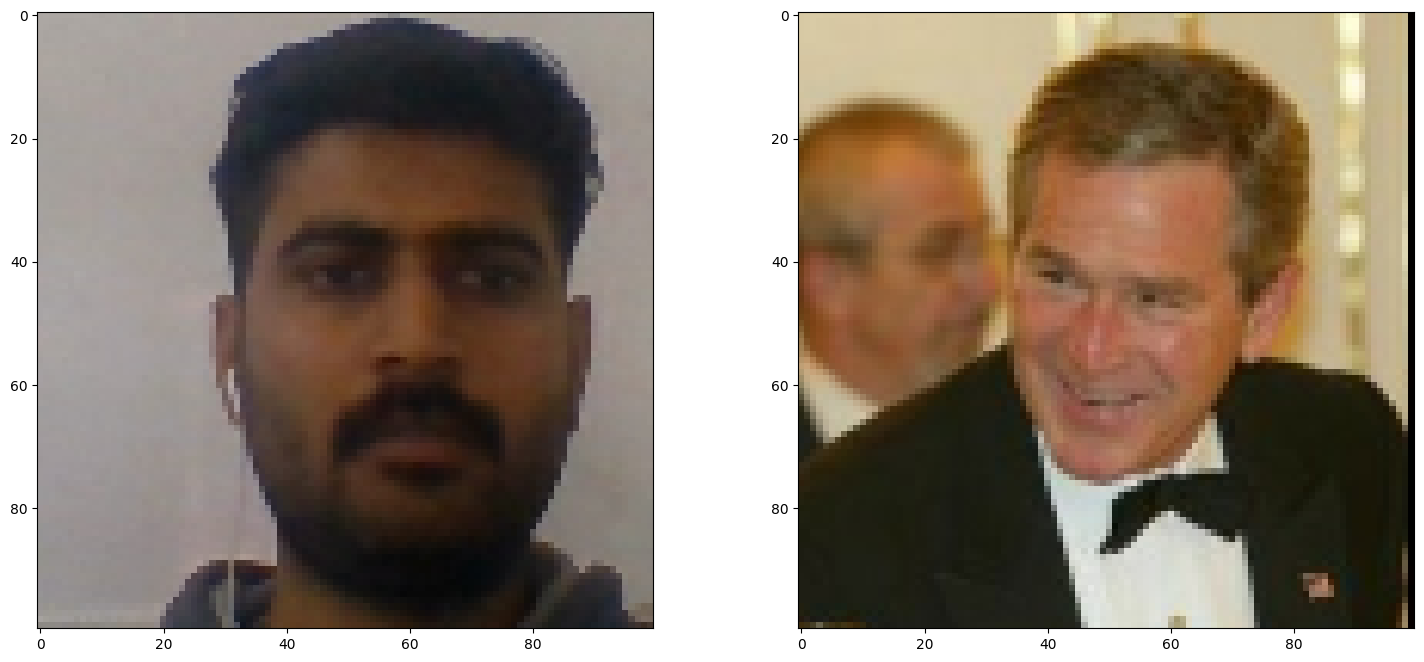

In [44]:
import matplotlib.pyplot as plt
import keras

# Set plot size
plt.figure(figsize=(18, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[6])

plt.subplot(1,2,2)
plt.imshow(test_val[6])
plt.show()

In [48]:
y_true[7]

1.0

In [49]:
yhat[7]

array([1.], dtype=float32)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
siamese_model = load_model('siamesem_model.h5', 
                           custom_objects ={'L1Dist': L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy} )

In [5]:
siamese_model

Signature:
tf.keras.models.load_model(
    filepath,
    custom_objects=None,
    compile=True,
    options=None,
)
Source:   
@keras_export("keras.models.load_model")
@traceback_utils.filter_traceback
def load_model(filepath, custom_objects=None, compile=True, options=None):
    """Loads a model saved via `model.save()`.

    Usage:

    >>> model = tf.keras.Sequential([
    ...     tf.keras.layers.Dense(5, input_shape=(3,)),
    ...     tf.keras.layers.Softmax()])
    >>> model.save('/tmp/model')
    >>> loaded_model = tf.keras.models.load_model('/tmp/model')
    >>> x = tf.random.uniform((10, 3))
    >>> assert np.allclose(model.predict(x), loaded_model.predict(x))

    Note that the model weights may have different scoped names after being
    loaded. Scoped names include the model/layer names, such as
    `"dense_1/kernel:0"`. It is recommended that you use the layer properties to
    access specific variables, e.g. `model.get_layer("dense_1").kernel`.

    Args:
        filepath: